In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybaseball
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from pybaseball.datahelpers.statcast_utils import add_spray_angle
from collections import defaultdict

In [2]:
# enable cache
pybaseball.cache.enable()

# Getting the data from statcast

In [3]:
# 2025 season (April 1 to May 31 so far)
start_date = '2025-04-01'
end_date = '2025-05-31'

In [ ]:
# statcast query
data = statcast(start_dt=start_date, end_dt=end_date)

In [5]:
# get batter ids
batter_ids = data['batter'].dropna().unique()

# Reverse lookup to get batter names from IDs
batter_info = playerid_reverse_lookup(batter_ids, key_type='mlbam')

# Create a full name column
batter_info['batter'] = batter_info['key_mlbam']  # Rename for merge compatibility
batter_info['batter_name'] = batter_info['name_first'] + ' ' + batter_info['name_last']

# Merge batter names back into the statcast data
data = data.merge(batter_info[['batter', 'batter_name']], on='batter', how='left')

# add spray angle
# adjusted = True makes it push/pull angles
data = add_spray_angle(data, adjusted=False)

# home runs with spray angle and distance
hr_data = data[
    (data['events'] == 'home_run') &
    (data['hit_distance_sc'].notna()) &
    (data['spray_angle'].notna())
].copy()

# convert from polar to xy
# spray_angle = 0 is dead center, negative is left, positive is right
angle_rad = np.radians(hr_data['spray_angle'])
hr_data['x'] = hr_data['hit_distance_sc'] * np.sin(angle_rad)
hr_data['y'] = hr_data['hit_distance_sc'] * np.cos(angle_rad)

# Finding Homerun Location Leaders

In [6]:
# Number of sectors for the outfield
n_sectors = 5

In [7]:
# Determine min and max spray angle
min_angle = hr_data.spray_angle.min()
max_angle = hr_data.spray_angle.max()

# Define bin edges and labels
bins = np.linspace(min_angle, max_angle, n_sectors + 1)
labels = [f"Sector {i+1}" for i in range(n_sectors)]
hr_data['sector'] = pd.cut(hr_data.spray_angle, bins=bins, labels=labels, include_lowest=True)

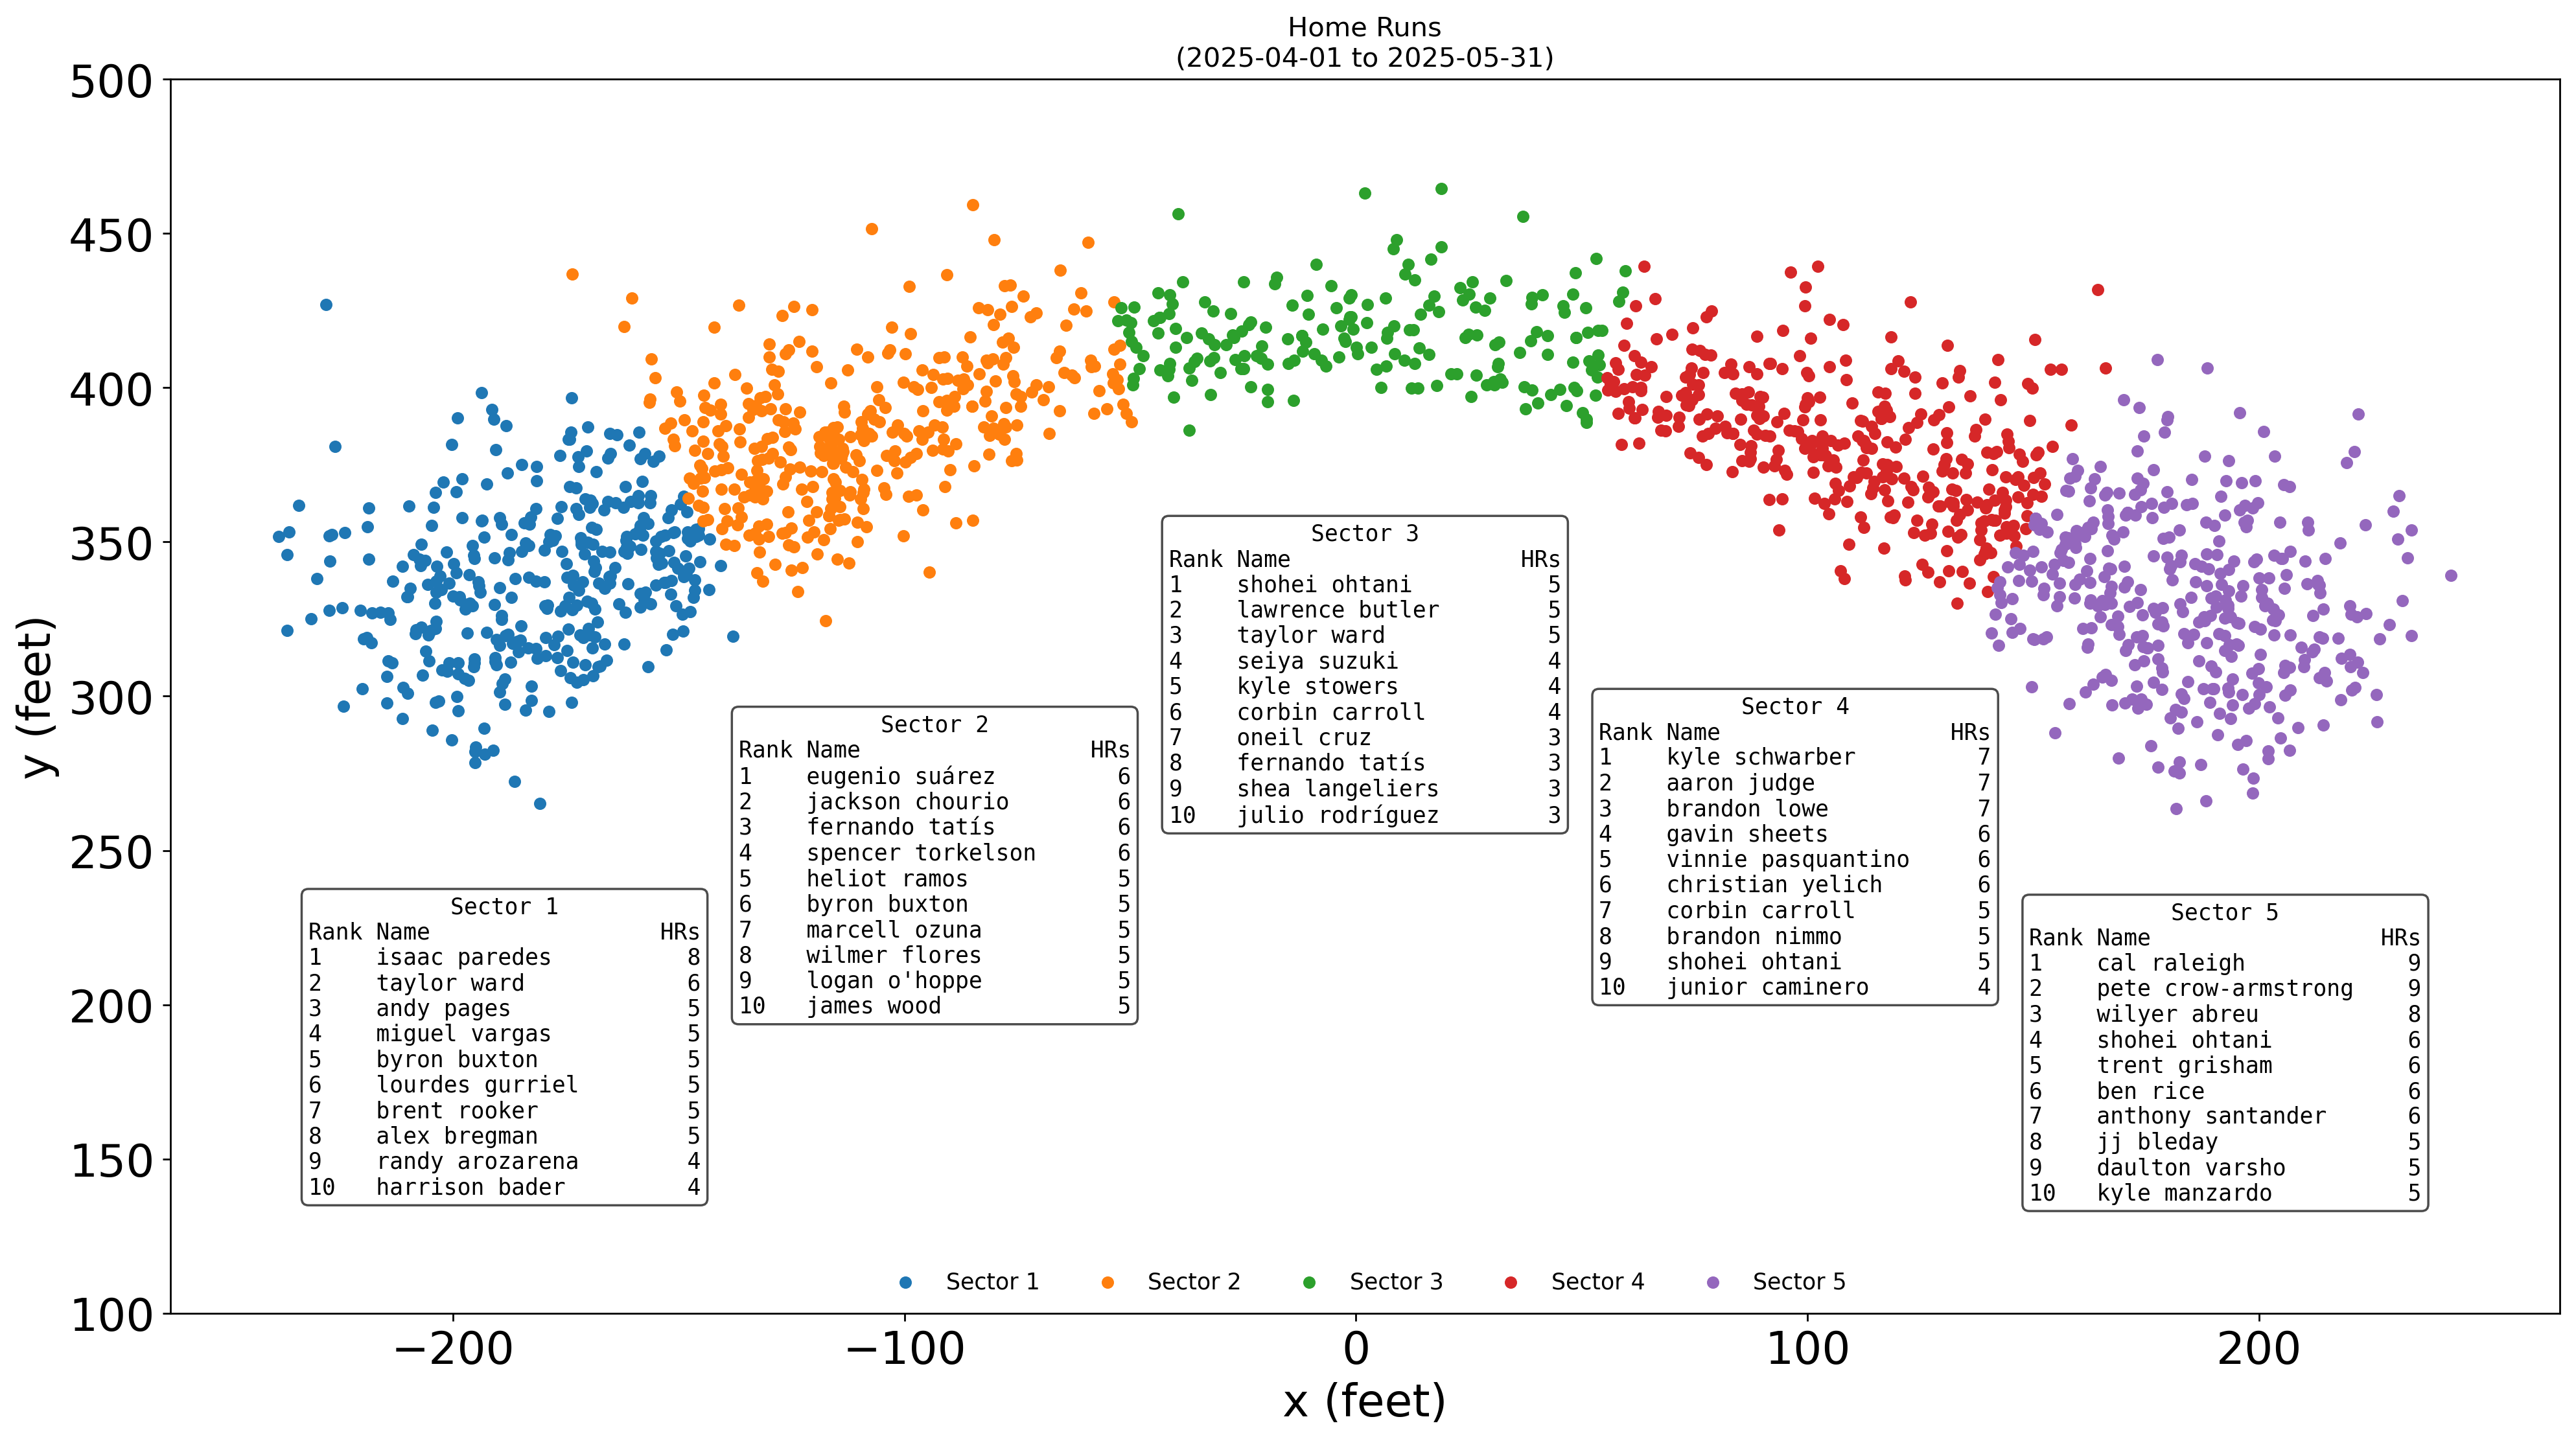

In [10]:
# Plotting
plt.figure(figsize=(16, 9), dpi=250)
sector_text_positions = []

# even x positions for leaderboards across data range
x_min, x_max = hr_data['x'].min(), hr_data['x'].max()
leaderboard_x_positions = np.linspace(x_min + 50, x_max - 50, n_sectors)  # 50 margin to avoid edges

for i, label in enumerate(labels):
    subset = hr_data[hr_data['sector'] == label]
    plt.scatter(subset['x'], subset['y'], s=20, label=label)

    # use spaced positions for leaderboard text
    text_x = leaderboard_x_positions[i]

    min_y = subset['y'].min()
    text_y = min_y - 30  # vertical position below cluster

    top_batters = subset['batter_name'].value_counts().head(10)

    name_col_width = 20
    leaderboard_lines = [f"{'Rank':<4} {'Name':<{name_col_width}} {'HRs':>3}"]
    leaderboard_lines += [
        f"{i+1:<4} {name:<{name_col_width}} {count:>3}" for i, (name, count) in enumerate(top_batters.items())
    ]
    leaderboard_text = f"{label}\n" + "\n".join(leaderboard_lines)

    sector_text_positions.append((text_x, text_y, leaderboard_text))

plt.title(f'Home Runs\n({start_date} to {end_date})')
plt.xlabel('x (feet)',fontsize=20)
plt.ylabel('y (feet)',fontsize=20)
plt.ylim(100, 500)
plt.legend(frameon=False,loc='lower center',ncols=n_sectors)
plt.tick_params(axis='both', which='major', labelsize=20)  # increase as needed


for x, y, text in sector_text_positions:
    plt.text(x, y, text, ha='center', va='top',
             fontfamily='monospace', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

plt.tight_layout()
plt.show()